In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons, load_iris
from sklearn.model_selection import train_test_split

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __p

**Sanity Check**

---

For this task, I created the same architecture from Course 11: a fully connected layer with 2 units followed by another layer with 1 unit. The activation function for the first layer is **tanh** and for the second layer is **sigmoid**.

In [0]:
model_sc = tf.keras.Sequential([
  tf.keras.layers.Dense(2, input_shape=(2,), activation=tf.nn.tanh),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [34]:
model_sc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 6         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


Here I initialized all weights with 1 and all biases with 0.

In [0]:
W1 = np.array([[1, 1],
               [1, 1]],
              dtype=np.float32)
b1 = np.array([0, 0],
              dtype=np.float32)
W2 = np.array([[1],
               [1]],
              dtype=np.float32)
b2 = np.array([0],
              dtype=np.float32)

weights = [W1, b1, W2, b2]
model_sc.set_weights(weights)

Generating the dataset

In [0]:
X_sc = np.random.randn(100, 2)
y_sc = model_sc.predict(X_sc)
y_sc = y_sc > 0.5

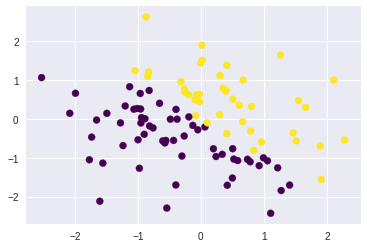

In [5]:
fig = plt.figure()
ax = fig.subplots()
ax.scatter(X_sc[:, 0], X_sc[:, 1], c=y_sc[:, 0], cmap='viridis')

Here I builded and trained a Bayesian network. For weights and biases I used a Normal distribution, then I computed the **output** using these parameters and the input X. After this, I created another variable with a Bernoulli distribution having **probs=outputs**. Given this, I performed MCMC to calculate the posterior distributions for weights and biases.

In [6]:
def sanity_check_model(X_):
  W1_ = tfp.edward2.Normal(loc=np.zeros((2, 2)), scale=np.ones((2, 2)), name='W1_')
  b1_ = tfp.edward2.Normal(loc=np.zeros((2,)), scale=np.ones((2,)), name='b1_')
  W2_ = tfp.edward2.Normal(loc=np.zeros((2, 1)), scale=np.ones((2, 1)), name='W2_')
  b2_ = tfp.edward2.Normal(loc=np.zeros((1,)), scale=np.ones((1,)), name='b2_')
  
  probs = tf.nn.sigmoid(tf.matmul(tf.nn.tanh(tf.matmul(X_, W1_) + b1_), W2_) + b2_)
  net = tfp.edward2.Bernoulli(probs=probs, name='net')
  
  return net 
  
log_joint = tfp.edward2.make_log_joint_fn(sanity_check_model)

def target_log_prob_fn(W1_, b1_, W2_, b2_):
  return log_joint(
      X_=X_sc,
      W1_=W1_,
      b1_=b1_,
      W2_=W2_,
      b2_=b2_,
      net=y_sc)

num_results = 5000
num_burnin_steps = 3000

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[
        tf.random.normal([2, 2], name='init_W1_', dtype=tf.float64),
        tf.random.normal([2,], name='init_b1_', dtype=tf.float64),
        tf.random.normal([2, 1], name='init_W2_', dtype=tf.float64),
        tf.random.normal([1,], name='init_b2_', dtype=tf.float64)
    ],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=0.05,
        num_leapfrog_steps=3))

W1_, b1_, W2_, b2_ = states

print('Training..')

with tf.Session() as sess:
  [
    W1_sample,
    b1_sample,
    W2_sample,
    b2_sample
  ] = sess.run([
    W1_,
    b1_,
    W2_,
    b2_
  ])

Training..


To predict new examples using the posterior distributions computed above I used an interceptor.

In [0]:
def interceptor(rv_constructor, *rv_args, **rv_kwargs):
  name = rv_kwargs.pop("name")
  if name == "W1_":
    rv_kwargs["value"] = np.mean(W1_sample, 0)
  elif name == "b1_":
    rv_kwargs["value"] = np.mean(b1_sample, 0)
  elif name == "W2_":
    rv_kwargs["value"] = np.mean(W2_sample, 0)
  elif name == "b2_":
    rv_kwargs["value"] = np.mean(b2_sample, 0)
  return rv_constructor(*rv_args, **rv_kwargs)

with tfp.edward2.interception(interceptor):
  posterior = sanity_check_model(X_=X_sc)

with tf.Session() as sess:
  posterior_predictive = sess.run(
      posterior.distribution.sample(sample_shape=(500)))

I generated 500 examples given X_sc and I computed the mean accuracy for this examples.

In [8]:
acc = []
y_true = y_sc
for i in range(posterior_predictive.shape[0]):
  y_pred = posterior_predictive[i, :, :]
  a = accuracy_score(y_true[:, 0], y_pred[:, 0].astype(np.bool))
  acc.append(a)

print('Mean accuracy: {0}'.format(sum(acc) /  len(acc)))

Mean accuracy: 0.8996000000000002


Plots to visualize the posterior distribution for the weights.

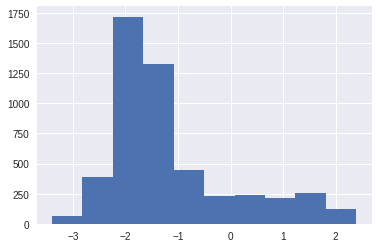

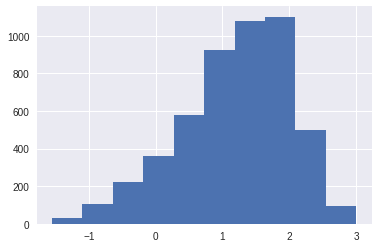

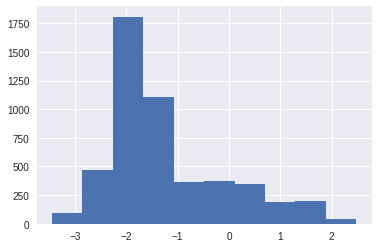

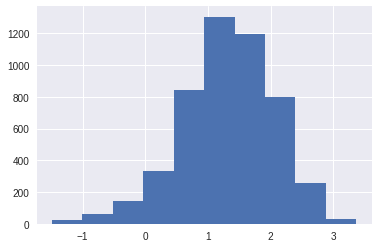

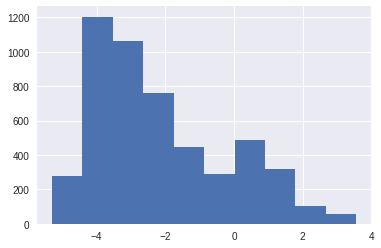

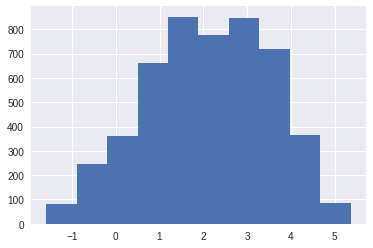

In [9]:
fig = plt.figure()
ax = fig.subplots()
ax.hist(W1_sample[:, 0, 0])

fig = plt.figure()
ax = fig.subplots()
ax.hist(W1_sample[:, 0, 1])

fig = plt.figure()
ax = fig.subplots()
ax.hist(W1_sample[:, 1, 0])

fig = plt.figure()
ax = fig.subplots()
ax.hist(W1_sample[:, 1, 1])

fig = plt.figure()
ax = fig.subplots()
ax.hist(W2_sample[:, 0, 0])

fig = plt.figure()
ax = fig.subplots()
ax.hist(W2_sample[:, 1, 0])

plt.show()

**Binary Classification**

---

For this task I used the moon dataset and I created a simple architecture with one hidden layer with 64 units. Also, I compared the Bayesian network with a normal network, both having the same architecture and hyperparameters.

In [0]:
X_train, y_train = make_moons(n_samples=1000, noise=0.2)
X_test, y_test = make_moons(n_samples=100, noise=0.2)

y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

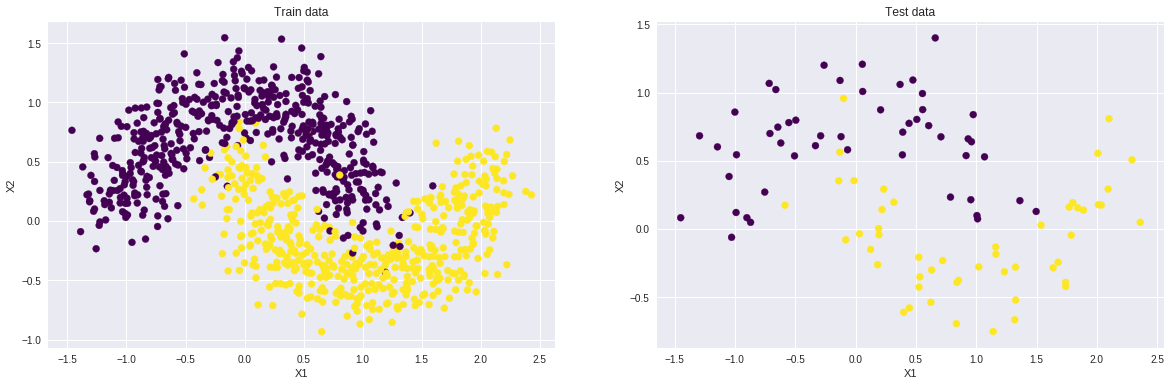

In [29]:
fig = plt.figure(figsize=(20, 6))
ax1, ax2 = fig.subplots(1, 2)
ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train[:, 0], cmap='viridis')
ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_test[:, 0], cmap='viridis')
ax1.set_title('Train data')
ax2.set_title('Test data')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
plt.show()

Here I builded and trained a Bayesian network. For weights and biases I used a Normal distribution, then I computed the **output** using these parameters and the input X. After this, I created another variable with a Bernoulli distribution having **probs=outputs**. Given this, I performed MCMC to calculate the posterior distributions for weights and biases.

In [30]:
NUM_CLASSES = 1
NUM_FEATURES = 2
NEURONS = 64

def binary_model(X_):
  binary_W1_ = tfp.edward2.Normal(loc=np.zeros((NUM_FEATURES, NEURONS)), scale=np.ones((NUM_FEATURES, NEURONS)), name='binary_W1_')
  binary_b1_ = tfp.edward2.Normal(loc=np.zeros((NEURONS,)), scale=np.ones((NEURONS,)), name='binary_b1_')
  binary_W2_ = tfp.edward2.Normal(loc=np.zeros((NEURONS, NUM_CLASSES)), scale=np.ones((NEURONS, NUM_CLASSES)), name='binary_W2_')
  binary_b2_ = tfp.edward2.Normal(loc=np.zeros((NUM_CLASSES,)), scale=np.ones((NUM_CLASSES,)), name='binary_b2_')
  
  binary_probs = tf.nn.sigmoid(tf.matmul(tf.nn.relu(tf.matmul(X_, binary_W1_) + binary_b1_), binary_W2_) + binary_b2_)
  binary_net = tfp.edward2.Bernoulli(probs=binary_probs, name='binary_net')
  
  return binary_net 
  
binary_log_joint = tfp.edward2.make_log_joint_fn(binary_model)

def binary_target_log_prob_fn(binary_W1_, binary_b1_, binary_W2_, binary_b2_):
  return binary_log_joint(
      X_=X_train,
      binary_W1_=binary_W1_,
      binary_b1_=binary_b1_,
      binary_W2_=binary_W2_,
      binary_b2_=binary_b2_,
      binary_net=y_train)

binary_num_results = 5000
binary_num_burnin_steps = 3000

binary_states, binary_kernel_results = tfp.mcmc.sample_chain(
    num_results=binary_num_results,
    num_burnin_steps=binary_num_burnin_steps,
    current_state=[
        tf.random.normal([NUM_FEATURES, NEURONS], name='binary_init_W1_', dtype=tf.float64),
        tf.random.normal([NEURONS,], name='binary_init_b1_', dtype=tf.float64),
        tf.random.normal([NEURONS, NUM_CLASSES], name='binary_init_W2_', dtype=tf.float64),
        tf.random.normal([NUM_CLASSES,], name='binary_init_b2_', dtype=tf.float64)
    ],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=binary_target_log_prob_fn,
        step_size=0.005,
        num_leapfrog_steps=3))

binary_W1_, binary_b1_, binary_W2_, binary_b2_ = binary_states

print('Training..')

with tf.Session() as sess:
  [
    binary_W1_sample,
    binary_b1_sample,
    binary_W2_sample,
    binary_b2_sample
  ] = sess.run([
    binary_W1_,
    binary_b1_,
    binary_W2_,
    binary_b2_
  ])

Training..


To predict new examples using the posterior distributions computed above I used an interceptor.

In [0]:
def binary_interceptor(rv_constructor, *rv_args, **rv_kwargs):
  name = rv_kwargs.pop("name")
  if name == "binary_W1_":
    rv_kwargs["value"] = np.mean(binary_W1_sample, 0)
  elif name == "binary_b1_":
    rv_kwargs["value"] = np.mean(binary_b1_sample, 0)
  elif name == "binary_W2_":
    rv_kwargs["value"] = np.mean(binary_W2_sample, 0)
  elif name == "binary_b2_":
    rv_kwargs["value"] = np.mean(binary_b2_sample, 0)
  return rv_constructor(*rv_args, **rv_kwargs)

with tfp.edward2.interception(binary_interceptor):
  binary_posterior = binary_model(X_=X_test)

with tf.Session() as sess:
  binary_posterior_predictive = sess.run(
      binary_posterior.distribution.sample(sample_shape=(500)))

I generated 500 examples given X_test and I computed the mean accuracy for this examples.

In [32]:
acc = []
y_true = y_test
for i in range(binary_posterior_predictive.shape[0]):
  y_pred = binary_posterior_predictive[i, :, :]
  a = accuracy_score(y_true[:, 0], y_pred[:, 0].astype(np.bool))
  acc.append(a)

print('Mean accuracy: {0}'.format(sum(acc) /  len(acc)))

Mean accuracy: 0.8922199999999997


Plots to visualize the posterior distribution for the weights.

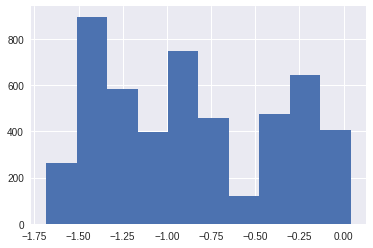

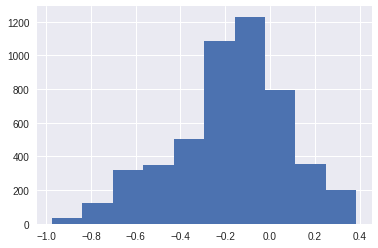

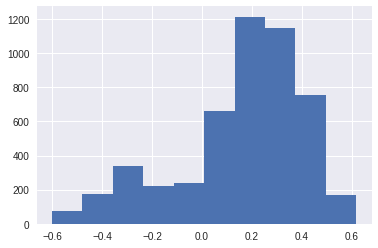

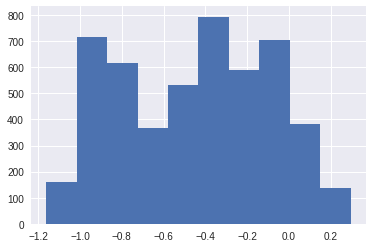

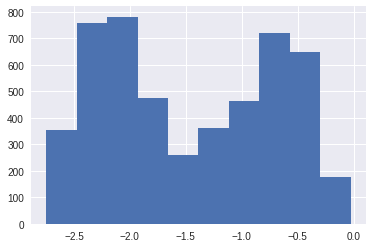

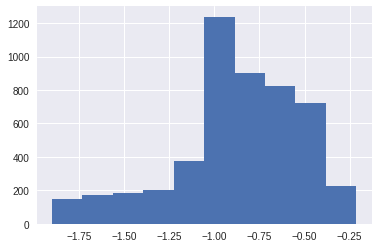

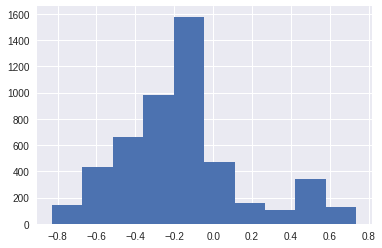

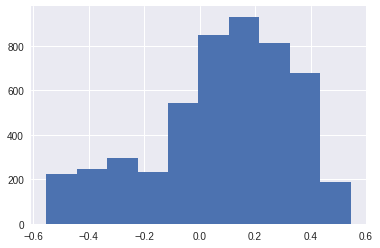

In [33]:
fig = plt.figure()
ax = fig.subplots()
ax.hist(binary_W1_sample[:, 0, 2])

fig = plt.figure()
ax = fig.subplots()
ax.hist(binary_W1_sample[:, 0, 5])

fig = plt.figure()
ax = fig.subplots()
ax.hist(binary_W1_sample[:, 0, 7])

fig = plt.figure()
ax = fig.subplots()
ax.hist(binary_W1_sample[:, 0, 11])

fig = plt.figure()
ax = fig.subplots()
ax.hist(binary_W1_sample[:, 1, 2])

fig = plt.figure()
ax = fig.subplots()
ax.hist(binary_W1_sample[:, 1, 5])

fig = plt.figure()
ax = fig.subplots()
ax.hist(binary_W1_sample[:, 1, 7])

fig = plt.figure()
ax = fig.subplots()
ax.hist(binary_W1_sample[:, 1, 11])

plt.show()

Here I created the normal network for comparison.

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(NEURONS, activation=tf.nn.relu, input_shape=(NUM_FEATURES,)),
    tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.sigmoid)
])

model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              metrics=[tf.keras.metrics.categorical_accuracy])

model.fit(X_train, y_train, epochs=11, verbose=1)

Epoch 1/11
1000/1000 [==============================] - 1s 540us/step - loss: 0.4033 - categorical_accuracy: 1.0000
Epoch 2/11
1000/1000 [==============================] - 0s 104us/step - loss: 0.2837 - categorical_accuracy: 1.0000
Epoch 3/11
1000/1000 [==============================] - 0s 118us/step - loss: 0.2613 - categorical_accuracy: 1.0000
Epoch 4/11
1000/1000 [==============================] - 0s 107us/step - loss: 0.2427 - categorical_accuracy: 1.0000
Epoch 5/11
1000/1000 [==============================] - 0s 126us/step - loss: 0.2150 - categorical_accuracy: 1.0000
Epoch 6/11
1000/1000 [==============================] - 0s 104us/step - loss: 0.1866 - categorical_accuracy: 1.0000
Epoch 7/11
1000/1000 [==============================] - 0s 106us/step - loss: 0.1615 - categorical_accuracy: 1.0000
Epoch 8/11
1000/1000 [==============================] - 0s 108us/step - loss: 0.1395 - categorical_accuracy: 1.0000
Epoch 9/11
1000/1000 [==============================] - 0s 106us/step - 

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


The accuracy using a normal network.

In [18]:
y_pred = (model.predict(X_test) > 0.5).astype(np.int32)
print('Accuracy: {0}'.format(accuracy_score(y_test[:, 0], y_pred[:, 0])))

Accuracy: 0.96


**Multiclass Classification**

---

For this task I used the iris dataset and I created a simple architecture with one hidden layer with 128 units. Also, I compared the Bayesian network with a normal network, both having the same architecture and hyperparameters.

In [0]:
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

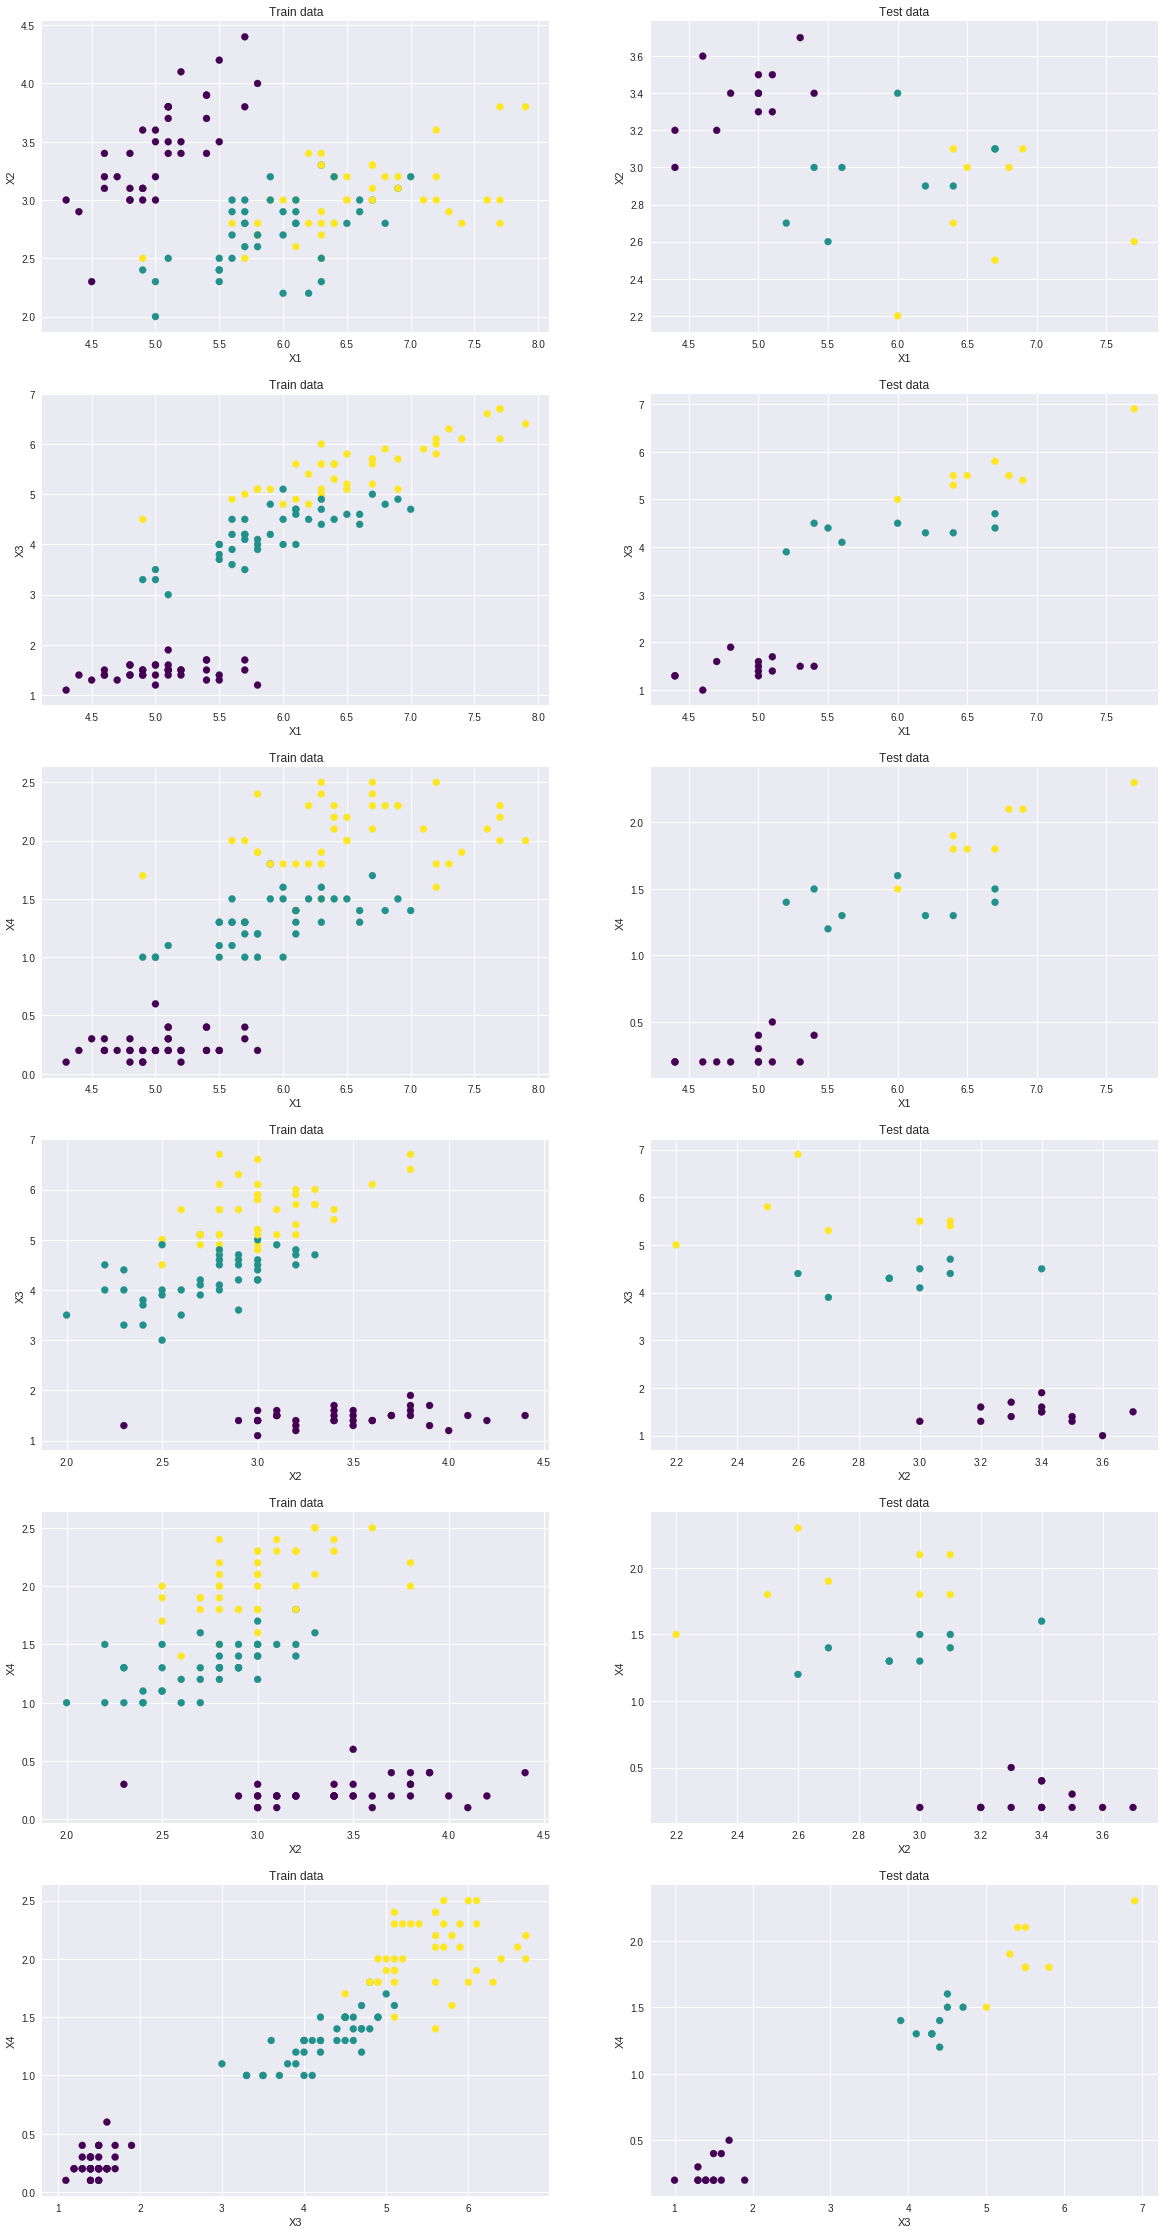

In [20]:
fig = plt.figure(figsize=(20, 40))

ax = fig.subplots(6, 2)
ax[0, 0].scatter(X_train[:, 0], X_train[:, 1], c=y_train[:], cmap='viridis')
ax[0, 1].scatter(X_test[:, 0], X_test[:, 1], c=y_test[:], cmap='viridis')
ax[0, 0].set_title('Train data')
ax[0, 1].set_title('Test data')
ax[0, 0].set_xlabel('X1')
ax[0, 0].set_ylabel('X2')
ax[0, 1].set_xlabel('X1')
ax[0, 1].set_ylabel('X2')

ax[1, 0].scatter(X_train[:, 0], X_train[:, 2], c=y_train[:], cmap='viridis')
ax[1, 1].scatter(X_test[:, 0], X_test[:, 2], c=y_test[:], cmap='viridis')
ax[1, 0].set_title('Train data')
ax[1, 1].set_title('Test data')
ax[1, 0].set_xlabel('X1')
ax[1, 0].set_ylabel('X3')
ax[1, 1].set_xlabel('X1')
ax[1, 1].set_ylabel('X3')

ax[2, 0].scatter(X_train[:, 0], X_train[:, 3], c=y_train[:], cmap='viridis')
ax[2, 1].scatter(X_test[:, 0], X_test[:, 3], c=y_test[:], cmap='viridis')
ax[2, 0].set_title('Train data')
ax[2, 1].set_title('Test data')
ax[2, 0].set_xlabel('X1')
ax[2, 0].set_ylabel('X4')
ax[2, 1].set_xlabel('X1')
ax[2, 1].set_ylabel('X4')

ax[3, 0].scatter(X_train[:, 1], X_train[:, 2], c=y_train[:], cmap='viridis')
ax[3, 1].scatter(X_test[:, 1], X_test[:, 2], c=y_test[:], cmap='viridis')
ax[3, 0].set_title('Train data')
ax[3, 1].set_title('Test data')
ax[3, 0].set_xlabel('X2')
ax[3, 0].set_ylabel('X3')
ax[3, 1].set_xlabel('X2')
ax[3, 1].set_ylabel('X3')

ax[4, 0].scatter(X_train[:, 1], X_train[:, 3], c=y_train[:], cmap='viridis')
ax[4, 1].scatter(X_test[:, 1], X_test[:, 3], c=y_test[:], cmap='viridis')
ax[4, 0].set_title('Train data')
ax[4, 1].set_title('Test data')
ax[4, 0].set_xlabel('X2')
ax[4, 0].set_ylabel('X4')
ax[4, 1].set_xlabel('X2')
ax[4, 1].set_ylabel('X4')

ax[5, 0].scatter(X_train[:, 2], X_train[:, 3], c=y_train[:], cmap='viridis')
ax[5, 1].scatter(X_test[:, 2], X_test[:, 3], c=y_test[:], cmap='viridis')
ax[5, 0].set_title('Train data')
ax[5, 1].set_title('Test data')
ax[5, 0].set_xlabel('X3')
ax[5, 0].set_ylabel('X4')
ax[5, 1].set_xlabel('X3')
ax[5, 1].set_ylabel('X4')

plt.show()

Here I builded and trained a Bayesian network. For weights and biases I used a Normal distribution, then I computed the **output** using these parameters and the input X. After this, I created another variable with a Categorical distribution having **probs=outputs**. Given this, I performed MCMC to calculate the posterior distributions for weights and biases.

In [21]:
NUM_CLASSES = 3
NUM_FEATURES = 4
NEURONS = 128

def multiclass_model(X_):
  multiclass_W1_ = tfp.edward2.Normal(loc=np.zeros((NUM_FEATURES, NEURONS)), scale=np.ones((NUM_FEATURES, NEURONS)), name='multiclass_W1_')
  multiclass_b1_ = tfp.edward2.Normal(loc=np.zeros((NEURONS,)), scale=np.ones((NEURONS,)), name='multiclass_b1_')
  multiclass_W2_ = tfp.edward2.Normal(loc=np.zeros((NEURONS, NUM_CLASSES)), scale=np.ones((NEURONS, NUM_CLASSES)), name='multiclass_W2_')
  multiclass_b2_ = tfp.edward2.Normal(loc=np.zeros((NUM_CLASSES,)), scale=np.ones((NUM_CLASSES,)), name='multiclass_b2_')
  
  multiclass_probs = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(X_, multiclass_W1_) + multiclass_b1_), multiclass_W2_) + multiclass_b2_)
  multiclass_net = tfp.edward2.Categorical(probs=multiclass_probs, name='multiclass_net')
  
  return multiclass_net 
  
multiclass_log_joint = tfp.edward2.make_log_joint_fn(multiclass_model)

def multiclass_target_log_prob_fn(multiclass_W1_, multiclass_b1_, multiclass_W2_, multiclass_b2_):
  return multiclass_log_joint(
      X_=X_train,
      multiclass_W1_=multiclass_W1_,
      multiclass_b1_=multiclass_b1_,
      multiclass_W2_=multiclass_W2_,
      multiclass_b2_=multiclass_b2_,
      multiclass_net=y_train)

multiclass_num_results = 5000
multiclass_num_burnin_steps = 3000

multiclass_states, multiclass_kernel_results = tfp.mcmc.sample_chain(
    num_results=multiclass_num_results,
    num_burnin_steps=multiclass_num_burnin_steps,
    current_state=[
        tf.random.normal([NUM_FEATURES, NEURONS], name='multiclass_init_W1_', dtype=tf.float64),
        tf.random.normal([NEURONS,], name='multiclass_init_b1_', dtype=tf.float64),
        tf.random.normal([NEURONS, NUM_CLASSES], name='multiclass_init_W2_', dtype=tf.float64),
        tf.random.normal([NUM_CLASSES,], name='multiclass_init_b2_', dtype=tf.float64)
    ],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=multiclass_target_log_prob_fn,
        step_size=0.005,
        num_leapfrog_steps=1))

multiclass_W1_, multiclass_b1_, multiclass_W2_, multiclass_b2_ = multiclass_states

print('Training..')

with tf.Session() as sess:
  [
    multiclass_W1_sample,
    multiclass_b1_sample,
    multiclass_W2_sample,
    multiclass_b2_sample
  ] = sess.run([
    multiclass_W1_,
    multiclass_b1_,
    multiclass_W2_,
    multiclass_b2_
  ])

Training..


To predict new examples using the posterior distributions computed above I used an interceptor.

In [0]:
def multiclass_interceptor(rv_constructor, *rv_args, **rv_kwargs):
  name = rv_kwargs.pop("name")
  if name == "multiclass_W1_":
    rv_kwargs["value"] = np.mean(multiclass_W1_sample, 0)
  elif name == "multiclass_b1_":
    rv_kwargs["value"] = np.mean(multiclass_b1_sample, 0)
  elif name == "multiclass_W2_":
    rv_kwargs["value"] = np.mean(multiclass_W2_sample, 0)
  elif name == "multiclass_b2_":
    rv_kwargs["value"] = np.mean(multiclass_b2_sample, 0)
  return rv_constructor(*rv_args, **rv_kwargs)

with tfp.edward2.interception(multiclass_interceptor):
  multiclass_posterior = multiclass_model(X_=X_test)

with tf.Session() as sess:
  multiclass_posterior_predictive = sess.run(
      multiclass_posterior.distribution.sample(sample_shape=(1000)))

I generated 500 examples given X_test and I computed the mean accuracy for this examples.

In [23]:
acc = []
y_true = y_test
for i in range(multiclass_posterior_predictive.shape[0]):
  y_pred = multiclass_posterior_predictive[i, :]
  a = accuracy_score(y_true[:], y_pred[:].astype(np.bool))
  acc.append(a)

print('Mean accuracy: {0}'.format(sum(acc) /  len(acc)))

Mean accuracy: 0.7331000000000076


Plots to visualize the posterior distribution for the weights.

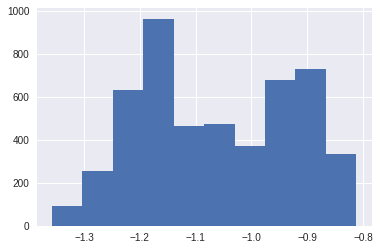

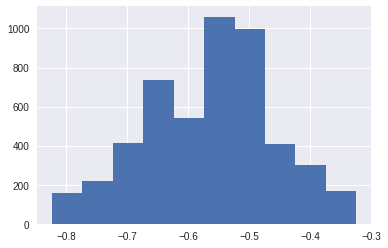

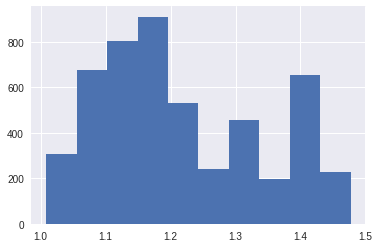

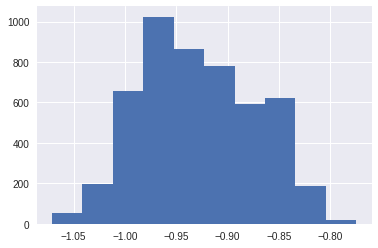

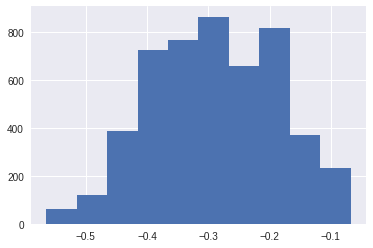

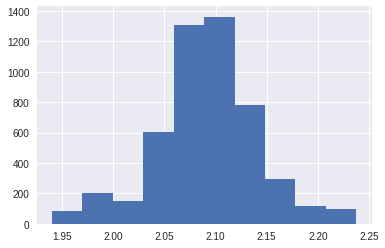

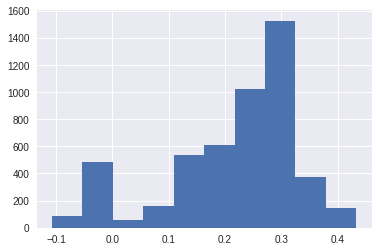

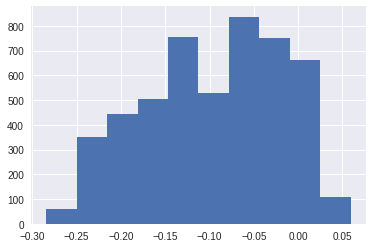

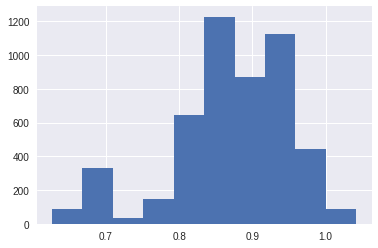

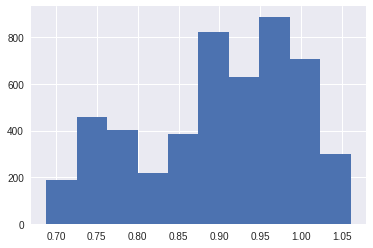

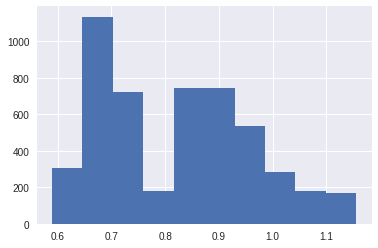

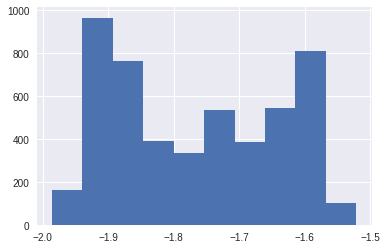

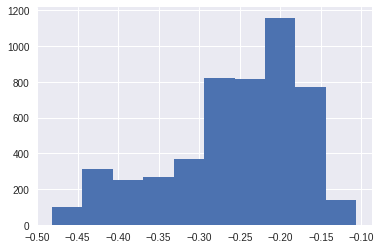

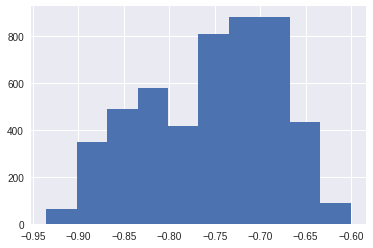

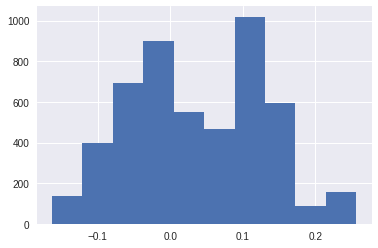

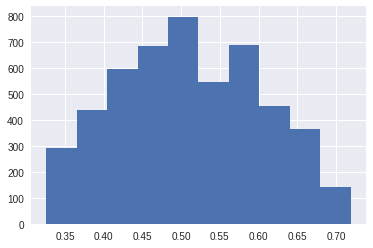

In [24]:
fig = plt.figure()
ax = fig.subplots()
ax.hist(multiclass_W1_sample[:, 0, 2])

fig = plt.figure()
ax = fig.subplots()
ax.hist(multiclass_W1_sample[:, 0, 5])

fig = plt.figure()
ax = fig.subplots()
ax.hist(multiclass_W1_sample[:, 0, 7])

fig = plt.figure()
ax = fig.subplots()
ax.hist(multiclass_W1_sample[:, 0, 11])

fig = plt.figure()
ax = fig.subplots()
ax.hist(multiclass_W1_sample[:, 1, 2])

fig = plt.figure()
ax = fig.subplots()
ax.hist(multiclass_W1_sample[:, 1, 5])

fig = plt.figure()
ax = fig.subplots()
ax.hist(multiclass_W1_sample[:, 1, 7])

fig = plt.figure()
ax = fig.subplots()
ax.hist(multiclass_W1_sample[:, 1, 11])

fig = plt.figure()
ax = fig.subplots()
ax.hist(multiclass_W1_sample[:, 2, 2])

fig = plt.figure()
ax = fig.subplots()
ax.hist(multiclass_W1_sample[:, 2, 5])

fig = plt.figure()
ax = fig.subplots()
ax.hist(multiclass_W1_sample[:, 2, 7])

fig = plt.figure()
ax = fig.subplots()
ax.hist(multiclass_W1_sample[:, 2, 11])

fig = plt.figure()
ax = fig.subplots()
ax.hist(multiclass_W1_sample[:, 3, 2])

fig = plt.figure()
ax = fig.subplots()
ax.hist(multiclass_W1_sample[:, 3, 5])

fig = plt.figure()
ax = fig.subplots()
ax.hist(multiclass_W1_sample[:, 3, 7])

fig = plt.figure()
ax = fig.subplots()
ax.hist(multiclass_W1_sample[:, 3, 11])

plt.show()

Here I created the normal network for comparison.

In [25]:
y_train_one_hot = np.zeros((y_train.shape[0], 3))
for i, y in enumerate(y_train):
  y_train_one_hot[i, y] = 1
  
model_ = tf.keras.Sequential([
    tf.keras.layers.Dense(NEURONS, activation=tf.nn.relu, input_shape=(NUM_FEATURES,)),
    tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax)
])

model_.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
              metrics=[tf.keras.metrics.categorical_accuracy])

model_.fit(X_train, y_train_one_hot, epochs=20, verbose=1)

Epoch 1/20
120/120 [==============================] - 1s 5ms/step - loss: 1.0885 - categorical_accuracy: 0.2833
Epoch 2/20
120/120 [==============================] - 0s 174us/step - loss: 1.0049 - categorical_accuracy: 0.1667
Epoch 3/20
120/120 [==============================] - 0s 138us/step - loss: 0.9446 - categorical_accuracy: 0.3000
Epoch 4/20
120/120 [==============================] - 0s 158us/step - loss: 0.8875 - categorical_accuracy: 0.4583
Epoch 5/20
120/120 [==============================] - 0s 146us/step - loss: 0.8405 - categorical_accuracy: 0.6667
Epoch 6/20
120/120 [==============================] - 0s 173us/step - loss: 0.8007 - categorical_accuracy: 0.7000
Epoch 7/20
120/120 [==============================] - 0s 169us/step - loss: 0.7682 - categorical_accuracy: 0.7000
Epoch 8/20
120/120 [==============================] - 0s 162us/step - loss: 0.7369 - categorical_accuracy: 0.7250
Epoch 9/20
120/120 [==============================] - 0s 182us/step - loss: 0.7100 - categ

In [26]:
model_.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
_________________________________________________________________


The accuracy using a normal network.

In [27]:
y_pred_one_hot = model_.predict(X_test)
y_pred = []
for y in y_pred_one_hot:
  y_pred.append(y.argmax())
y_pred = np.array(y_pred)

print('Accuracy: {0}'.format(accuracy_score(y_test[:], y_pred[:])))

Accuracy: 0.8333333333333334
